핸즈온 7장 앙상블 학습과 랜덤 포레스트 (p. 245-271)

- 앙상블 방법: 일련의 예측기로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 얻는 것





## 7.1 투표 기반 분류기

- **직접 투표 분류기(Hard Voting)**: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (다수결 투표)

- 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음. (원리: 큰 수의 법칙 - 더 많을수록 확률이 증가)

- Tip) 앙상블 방법은 예측기가 가능한 한 서로 독립적일 떄 최고의 성능을 발휘한다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다. (분류기가 독립이 아니면 분류기들이 같은 종류의 오차를 만들기 쉬워 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐)

- **간접 투표 분류기(Soft Voting)**: 모든 분류기가 클래스의 확률을 예측할 수 있으면(predict_proba() 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측함. 

- 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음.

- SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 함.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [44]:
# Hard Voting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Support Vector Classifier

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [45]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
# VotingClassifier 분류기 성능이 가장 좋음.

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


In [46]:
# Soft Voting
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [47]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
# VotingClassifier 분류기 성능이 가장 좋음. 
# Soft Voting이 Hard Voting보다 성능이 좋음.

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2 배깅과 페이스팅

- **배깅**: 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킬 때 훈련 세트에서 **중복을 허용**하여 샘플링하는 방식 (부트스트랩)

- **페이스팅**: 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킬 때 훈련 세트에서 **중복을 허용하지 않고** 샘플링하는 방식 

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듬. 수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산함. 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함. 

### 7.2.1 사이킷런의 배깅과 페이스팅

- BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용함.

- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높지만, 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴. 

- 전반적으로 배깅이 더 나은 모델을 만듬.

In [6]:
# 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨.
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, # 결정 트리 분류기 500개의 앙상블을 훈련
    max_samples=100, bootstrap=True, n_jobs=-1) # bootstrap이 True이면 배깅, False이면 페이스팅
    # n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어수 (-1이면 가능한 모든 코어 사용)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


In [8]:
# 단일 결정 트리 모형
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [9]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
  x1s = np.linspace(axes[0], axes[1], 100)
  x2s = np.linspace(axes[2], axes[3], 100)
  x1, x2 = np.meshgrid(x1s, x2s)
  X_new = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X_new).reshape(x1.shape)

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

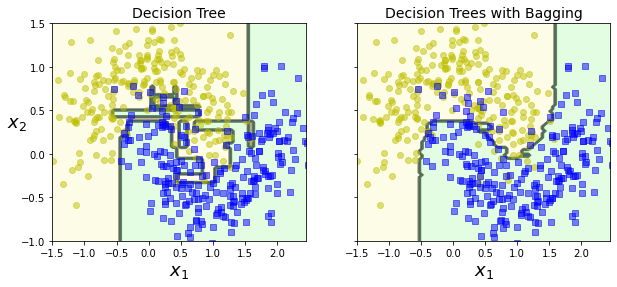

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

### 7.2.2 oob 평가

- BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택함. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미함. 선택되지 않은 훈련 샘플의 나머지 37%를 oob (out of bag)샘플이라고 부름. 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음.

- BaggingClassifier에서 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행함.

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)
# oob 샘플로 평가한 값과 비슷함.

0.912

In [14]:
# oob_decision_function: 각 훈련 샘플의 클래스 확률을 반환
bag_clf.oob_decision_function_
# 첫 번째 훈련 샘플이 양성 클래스에 속할 확률은 60%

array([[0.34408602, 0.65591398],
       [0.375     , 0.625     ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.11173184, 0.88826816],
       [0.35789474, 0.64210526],
       [0.01052632, 0.98947368],
       [0.98830409, 0.01169591],
       [0.98484848, 0.01515152],
       [0.79329609, 0.20670391],
       [0.00537634, 0.99462366],
       [0.72774869, 0.27225131],
       [0.84210526, 0.15789474],
       [0.96373057, 0.03626943],
       [0.05181347, 0.94818653],
       [0.        , 1.        ],
       [0.97159091, 0.02840909],
       [0.92352941, 0.07647059],
       [0.99435028, 0.00564972],
       [0.02673797, 0.97326203],
       [0.38297872, 0.61702128],
       [0.89      , 0.11      ],
       [1.        , 0.        ],
       [0.97474747, 0.02525253],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.60824742, 0.39175258],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 max_features, bootstrap_features로 조절되는 특성 샘플링도 지원함.각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨.

- **랜덤 패치 방식**: 훈련 특성과 샘플을 모두 샘플링하는 것

- **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤.

## 7.4 랜덤 포레스트

랜덤 포레스트: 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블

- max_samples를 훈련 세트의 크기로 지정

- 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함. 이는 결정 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만듬.

In [15]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1) # 500개 트리로 이루어짐
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.92

In [16]:
# BaggingClassifier를 사용하여 RandomForestClassifier와 유사하게 만듬.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16), # max_features: The number of features to consider when looking for the best split:
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### 7.4.1 엑스트라 트리



- 랜덤 포레스트는 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함.

- 익스트림 랜덤 트리(엑스트라 트리): 극단적으로 무작위한 트리의 랜덤 포레스트

- 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름.

- Tip) RandomForestClassifier가 ExtraTreeClassifier보다 더 나을지 혹은 나쁠지 예단하기는 어려움. 일반적으로 둘 다 시도해보고 교챠 검증으로 비교해보는 것이 유일한 방법임. (그리트 탐색으로 하이퍼파라미터 튜닝)

### 7.4.2 특성 중요도

- 랜덤 포레스트는 특성 선택 시 어떤 특성이 중요한지 빠르게 확인할 수 있어 편리함.

- 랜덤 포레스트의 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도(가중치 평균)를 특정함. 각 노드의 가중치는 연관된 훈련 샘플수와 같음.

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)
# petal length와 petal width가 각각 44%, 42% 영향을 미치므로 중요한 특성임.

sepal length (cm) 0.09661795319288248
sepal width (cm) 0.023330559722869088
petal length (cm) 0.4491253775088289
petal width (cm) 0.43092610957541955


## 7.5 부스팅

- **부스팅**: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법 

  - **에이다부스트**

  - **그레이디언트 부스팅**

### 7.5.1 에이다부스트

- 에이다부스트: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 새로운 예측기를 만듬.

- 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만듬. 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임. 두 번째 분류기는 업데이트된 가중치를 사용하여 훈련 세트에서 훈련하고 다시 예측을 만듬. 그 다음에 다시 가중치를 업데이트하는 식으로 계속함.

- 연속된 학습 기법은 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화(또는 분할)을 할 수 없음.

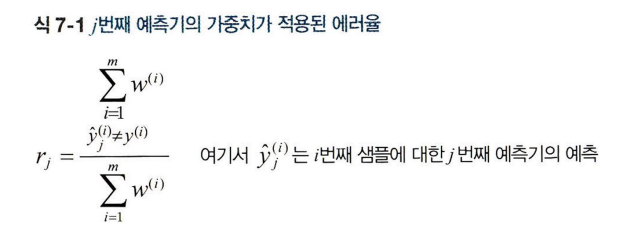

- 예측기가 정확할수록 가중치가 더 높아짐.

- 무작위로 예측하는 정도라면 가중치는 0, 무작위 추측보다 정확도가 낮으면 가중치는 음수가 됨.

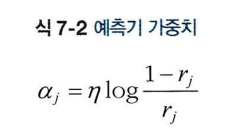


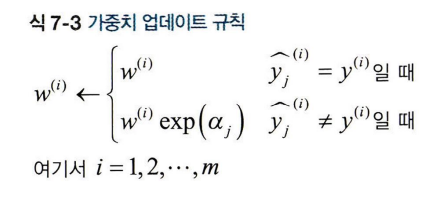

- 에이다부스트는 예측 시 단순히 모든 예측기의 예측을 계산하고 예측기 가중치$α$를 더해 예측 결과를 만듬. 가중치 합이 가장 큰 클래스가 예측 결과가 됨.

다음으로, 모든 샘플의 가중치를 정규화하고, 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됨.

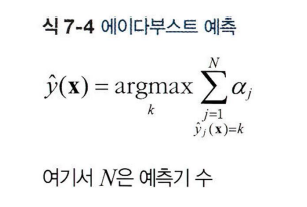

- SAMME: 에이다부스트의 다중 클래스 버전 (클래스가 2개이면 SAMME와 에이다부스트 동일)

- SAMME.R: 예측값 대신 클래스 확률에 기반하여 추정. 성능이 더 좋음.

- Tip) 에이다부스트 앙상블이 훈련 세트에 과대적합되면 추정기 수를 줄이거나 추정기의 규제를 더 강하게 함.

In [18]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

- 그레이디언트 부스팅: 이전 예측기가 만든 잔여 오차(residual error)에 새로운 학습기를 학습시킴.

In [19]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
X_new = np.array([[0.8]])

In [20]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)
# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 예측기 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)
# 두 번째 예측기에서 생긴 잔여 오차에 세 번째 예측기 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)
# 새로운 샘플에 대한 예측: 모든 트리의 예측을 합함.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [21]:
y_pred

array([0.75026781])

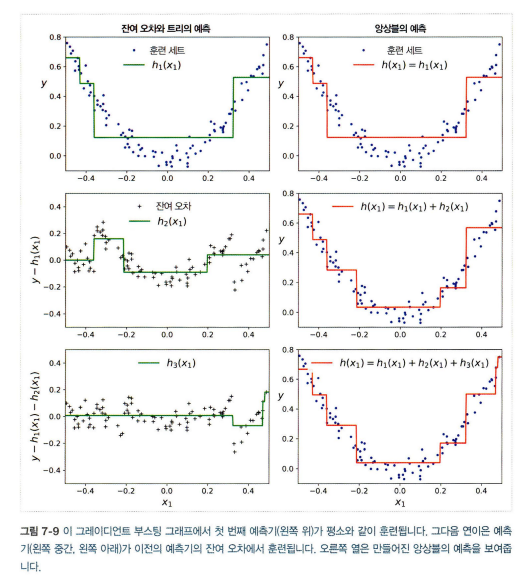

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
# learning_rate: 각 트리의 기여 정도
# 축소(규제 방법): learning_rate를 0.1처럼 낮게 설정하여 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐.
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

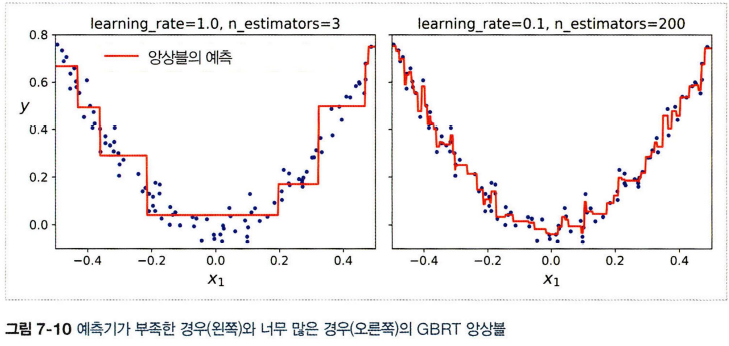

#### 최적의 트리수 찾기:

- 조기종료 기법 이용

- staged_predict() 메서드 이용: 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순환하는 반복자를 반환함.

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X,y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) # 120개의 트리로 GBRT앙상블 훈련
gbrt.fit(X_train, y_train)
# 각 훈련단계(1~120 개의 트리 훈련)에서 검증 오차 측정
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)] 
bst_n_estimators = np.argmin(errors) + 1 # 최적의 트리수
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)
# 최적의 트리수: 85개

GradientBoostingRegressor(max_depth=2, n_estimators=67)

In [53]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

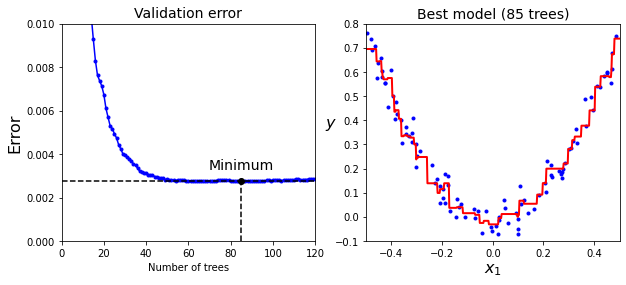

In [39]:
# 최적의 트리수 찾기
min_error = np.min(errors)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(np.arange(1, len(errors)+1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators],[0,min_error],"k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")

plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [54]:
# 조기종료를 사용하여 트리수 튜닝
# warm_start=True로 설정하면 사이킷런이 fit() 메서드가 호풀될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌.
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
# 5번 반복 동안 검증 오차가 향상하지 않으면 훈련을 멈춤 (조기종료)
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error<min_val_error:
    min_val_error = val_error
    error_going_up=0
  else:
    error_going_up+=1
    if error_going_up == 5:
      break # 조기종료

#### 확률적 그레이디언트 부스팅

- GradientBoostingRegressor의 subsample 매개변수: 각 트리가 훈련할 떄 사용할 훈련 샘플의 비율 지정 

ex. subsample=0.25: 각 트리가 무작위로 선택된 25%의 훈련 샘플로 학습됨.

- 편향이 높아지는 대신 분산이 낮아짐.

- 훈련속도를 높임.

#### XGBoost 

- 익스트림 그레이디언트 부스팅의 약자

- 머신러닝 경연 대회에서 우승 후보들이 사용하는 중요 도구 중 하나

In [58]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)  

[04:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.09548600187023576


In [60]:
# XGBoost의 조기종료 기능
xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)], early_stopping_rounds=2, verbose=0)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error) 

[04:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.08765751538152779


## 7.6 스태킹

- 예측기 각각이 다른 값을 예측하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력받아 최종 예측을 만듬.

- 블렌더를 학습시키는 일반적인 방법: 홀드 아웃 세트 사용



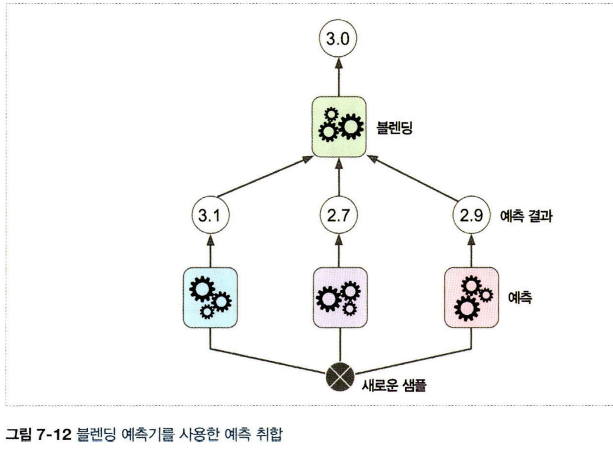

1. 훈련 세트를 2개의 서브셋으로 나누어 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됨.

2. 첫 번째 예측기를 사용해 두 번째 (홀드 아웃)세트에 대한 예측을 만듬. 

3. 홀드 아웃 세트의 각 샘플에 대해 3개의 예측값을 입력 특성으로 하는 새로운 훈련 세트를 만듬. 

4. 블렌더가 새 훈련 세트로 훈련됨. 즉, 첫 번째 레이어의 예측값을 가지고 타깃값을 예측하도록 학습됨.
